In [39]:
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
pgconn_asos = psycopg2.connect(dbname="asos", host="iemdb", user="nobody")
pgconn_iem = psycopg2.connect(dbname="iem", host="iemdb", user="nobody")
acursor = pgconn_asos.cursor()
icursor = pgconn_iem.cursor()

In [33]:
dates = []
icursor.execute("""
    with data as (
    SELECT day from summary s JOIN stations t on (s.iemid = t.iemid)
    WHERE t.id = 'DSM' and t.network = 'IA_ASOS' and extract(month from day) > 8
    and day > '2000-01-01' and min_tmpf < 33),
    agg1 as (
    SELECT day, rank() OVER (PARTITION by extract(year from day) ORDER by day ASC)
    from data)
    
    SELECT day, rank from agg1 where rank < 11 ORDER by day ASC
""")
for row in icursor:
    dates.append(row)
print dates

[(datetime.date(2000, 10, 5), 1L), (datetime.date(2000, 10, 6), 2L), (datetime.date(2000, 10, 7), 3L), (datetime.date(2000, 10, 8), 4L), (datetime.date(2000, 10, 9), 5L), (datetime.date(2000, 10, 10), 6L), (datetime.date(2000, 11, 7), 7L), (datetime.date(2000, 11, 8), 8L), (datetime.date(2000, 11, 9), 9L), (datetime.date(2000, 11, 10), 10L), (datetime.date(2001, 10, 17), 1L), (datetime.date(2001, 10, 25), 2L), (datetime.date(2001, 10, 26), 3L), (datetime.date(2001, 10, 27), 4L), (datetime.date(2001, 11, 9), 5L), (datetime.date(2001, 11, 19), 6L), (datetime.date(2001, 11, 20), 7L), (datetime.date(2001, 11, 27), 8L), (datetime.date(2001, 11, 28), 9L), (datetime.date(2001, 11, 29), 10L), (datetime.date(2002, 10, 13), 1L), (datetime.date(2002, 10, 16), 2L), (datetime.date(2002, 10, 20), 3L), (datetime.date(2002, 10, 23), 4L), (datetime.date(2002, 10, 24), 5L), (datetime.date(2002, 10, 31), 6L), (datetime.date(2002, 11, 1), 7L), (datetime.date(2002, 11, 2), 8L), (datetime.date(2002, 11, 4),

In [38]:
data = [[], [], [], [], [], [], [], [], [], []]
data2 = [[], [], [], [], [], [], [], [], [], []]
for (day, rank) in dates:
    table = "t%s_1minute" % (day.year,)
    acursor.execute("""
    SELECT valid, tmpf from %s WHERE station = 'DSM'
    and valid between '%s 00:00' and '%s 23:59' and tmpf is not null
    ORDER by valid ASC
    """ % (table, day.strftime("%Y-%m-%d"), day.strftime("%Y-%m-%d")))
    running = 0
    maxrunning = 0
    deghours = 0
    dhrunning = 0
    for row in acursor:
        if row[1] <= 32:
            running += 1
            dhrunning += ((32 - row[1]) / 60.)
        elif row[1] > 32:
            if running > maxrunning:
                maxrunning = running
                deghours = dhrunning
            running = 0
            dhrunning = 0
    if running > maxrunning:
        maxrunning = running
        deghours = dhrunning
    if maxrunning > 0:
        data[rank-1].append(maxrunning / 60.)
        data2[rank-1].append(deghours)
    print("%s rank:%s hours:%s rows:%s dh:%s" % (day, rank, maxrunning / 60., acursor.rowcount, deghours))

2000-10-05 rank:1 hours:0.0 rows:1440 dh:0
2000-10-06 rank:2 hours:3.35 rows:1440 dh:2.33333333333
2000-10-07 rank:3 hours:7.91666666667 rows:1392 dh:22.5833333333
2000-10-08 rank:4 hours:9.73333333333 rows:1440 dh:44.4833333333
2000-10-09 rank:5 hours:8.86666666667 rows:1440 dh:23.4666666667
2000-10-10 rank:6 hours:0.45 rows:1440 dh:0.0
2000-11-07 rank:7 hours:3.43333333333 rows:1440 dh:0.233333333333
2000-11-08 rank:8 hours:22.75 rows:1365 dh:97.6833333333
2000-11-09 rank:9 hours:23.0833333333 rows:1385 dh:86.6
2000-11-10 rank:10 hours:14.0666666667 rows:1440 dh:56.1333333333
2001-10-17 rank:1 hours:5.1 rows:1431 dh:7.03333333333
2001-10-25 rank:2 hours:1.26666666667 rows:1290 dh:0.783333333333
2001-10-26 rank:3 hours:7.46666666667 rows:1436 dh:21.3
2001-10-27 rank:4 hours:10.25 rows:1440 dh:76.1666666667
2001-11-09 rank:5 hours:5.18333333333 rows:1103 dh:9.78333333333
2001-11-19 rank:6 hours:1.86666666667 rows:209 dh:0.75
2001-11-20 rank:7 hours:9.01666666667 rows:1440 dh:36.05
2001

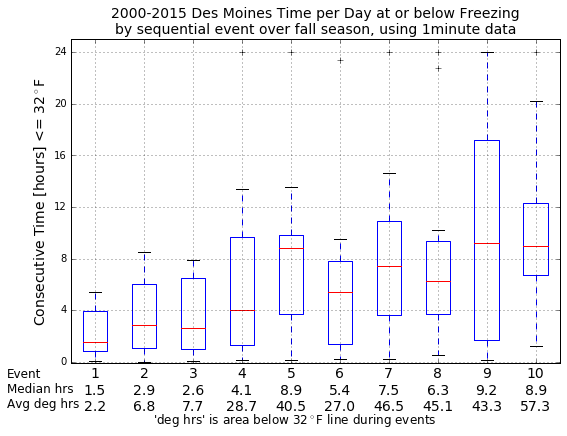

In [74]:
(fig, ax) = plt.subplots(1, 1, figsize=(8, 6))
res = ax.boxplot(data)
xlabels = []
for i, x in enumerate(data2):
    xlabels.append("%s\n%.1f\n%.1f" % (i+1, np.median(data[i]), np.average(x)))
res = ax.set_xticklabels(xlabels, fontsize=14)
ax.grid(True)
ax.set_ylabel("Consecutive Time [hours] <= 32$^\circ$F", fontsize=14)
fig.text(0.0, 0.14, "Event\nMedian hrs\nAvg deg hrs", va='top', fontsize=12)
fig.text(0.5, 0.01, "'deg hrs' is area below 32$^\circ$F line during events", ha='center',
        fontsize=12)
ax.set_title(("2000-2015 Des Moines Time per Day at or below Freezing\n"
              "by sequential event over fall season, using 1minute data"), fontsize=14)
ax.set_position([0.11, 0.15, 0.85, 0.75])
ax.set_yticks(range(0, 25, 4))
ax.set_ylim(-0.1, 25)
fig.savefig('161021.png')